In [1]:
import numpy as np

from tqdm import tqdm, trange

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

from torchvision.transforms import ToTensor
from torchvision.datasets.mnist import MNIST
from dataset import *

np.random.seed(0)
torch.manual_seed(0)

In [2]:
def get_positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result

In [3]:
def patchify(images, n_patches):
    n, c, h, w = images.shape

    assert h == w, "Patchify method is implemented for square images only"

    patches = torch.zeros(n, n_patches ** 2, h * w * c // n_patches ** 2)
    patch_size = h // n_patches

    for idx, image in enumerate(images):
        for i in range(n_patches):
            for j in range(n_patches):
                patch = image[:, i * patch_size: (i + 1) * patch_size, j * patch_size: (j + 1) * patch_size]
                patches[idx, i * n_patches + j] = patch.flatten()
    return patches

In [4]:
class MyMSA(nn.Module):
    def __init__(self, d, n_heads=2):
        super(MyMSA, self).__init__()
        self.d = d
        self.n_heads = n_heads

        assert d % n_heads == 0, f"Can't divide dimension {d} into {n_heads} heads"

        d_head = int(d / n_heads)
        self.q_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.k_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.v_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.d_head = d_head
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, sequences):
        # Sequences has shape (N, seq_length, token_dim)
        # We go into shape    (N, seq_length, n_heads, token_dim / n_heads)
        # And come back to    (N, seq_length, item_dim)  (through concatenation)
        result = []
        for sequence in sequences:
            seq_result = []
            for head in range(self.n_heads):
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]

                seq = sequence[:, head * self.d_head: (head + 1) * self.d_head]
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

                attention = self.softmax(q @ k.T / (self.d_head ** 0.5))
                seq_result.append(attention @ v)
            result.append(torch.hstack(seq_result))
        return torch.cat([torch.unsqueeze(r, dim=0) for r in result])

In [5]:
class MyViTBlock(nn.Module):
    def __init__(self, hidden_d, n_heads, mlp_ratio=4):
        super(MyViTBlock, self).__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads

        self.norm1 = nn.LayerNorm(hidden_d)
        self.mhsa = MyMSA(hidden_d, n_heads)
        self.norm2 = nn.LayerNorm(hidden_d)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_d, mlp_ratio * hidden_d),
            nn.GELU(),
            nn.Linear(mlp_ratio * hidden_d, hidden_d)
        )

    def forward(self, x):
        out = x + self.mhsa(self.norm1(x))
        out = out + self.mlp(self.norm2(out))
        return out

In [6]:
class MyViT(nn.Module):
    def __init__(self, chw, n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10):
        # Super constructor
        super(MyViT, self).__init__()
        
        # Attributes
        self.chw = chw # ( C , H , W )
        self.n_patches = n_patches
        self.n_blocks = n_blocks
        self.n_heads = n_heads
        self.hidden_d = hidden_d
        
        # Input and patches sizes
        assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

        # 1) Linear mapper
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)
        
        # 2) Learnable classification token
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))
        
        # 3) Positional embedding
        self.register_buffer('positional_embeddings', get_positional_embeddings(n_patches ** 2 + 1, hidden_d), persistent=False)
        
        # 4) Transformer encoder blocks
        self.blocks = nn.ModuleList([MyViTBlock(hidden_d, n_heads) for _ in range(n_blocks)])
        
        # 5) Classification MLPk
        self.mlp = nn.Sequential(
            nn.Linear(self.hidden_d, out_d),
            nn.Softmax(dim=-1)
        )

    def forward(self, images):
        # Dividing images into patches
        n, c, h, w = images.shape
        patches = patchify(images, self.n_patches).to(self.positional_embeddings.device)
        
        # Running linear layer tokenization
        # Map the vector corresponding to each patch to the hidden size dimension
        tokens = self.linear_mapper(patches)
        
        # Adding classification token to the tokens
        tokens = torch.cat((self.class_token.expand(n, 1, -1), tokens), dim=1)
        
        # Adding positional embedding
        out = tokens + self.positional_embeddings.repeat(n, 1, 1)
        
        # Transformer Blocks
        for block in self.blocks:
            out = block(out)
            
        # Getting the classification token only
        out = out[:, 0]
        
        return self.mlp(out) # Map to output dimension, output category distribution


In [7]:
# Loading data
transform = ToTensor()

train_set, val_set, test_set = generate_adni_datasets(datasplit=0.1)

train_loader = DataLoader(train_set, shuffle=True, batch_size=256)
val_loader = DataLoader(val_set, shuffle=True, batch_size=256)
test_loader = DataLoader(test_set, shuffle=False, batch_size=256)


[('C:/Users/Jun Khai/Documents/Uni/Year 5 Sem 2/PatternAnalysis-2023/recognition/45816967_ADNI_Vision_Transformer/data/ADNI_AD_NC_2D/AD_NC/train/AD/*', 1), ('C:/Users/Jun Khai/Documents/Uni/Year 5 Sem 2/PatternAnalysis-2023/recognition/45816967_ADNI_Vision_Transformer/data/ADNI_AD_NC_2D/AD_NC/train/NC/*', 0)]
[('C:/Users/Jun Khai/Documents/Uni/Year 5 Sem 2/PatternAnalysis-2023/recognition/45816967_ADNI_Vision_Transformer/data/ADNI_AD_NC_2D/AD_NC/test/AD/*', 1), ('C:/Users/Jun Khai/Documents/Uni/Year 5 Sem 2/PatternAnalysis-2023/recognition/45816967_ADNI_Vision_Transformer/data/ADNI_AD_NC_2D/AD_NC/test/NC/*', 0)]
[('C:/Users/Jun Khai/Documents/Uni/Year 5 Sem 2/PatternAnalysis-2023/recognition/45816967_ADNI_Vision_Transformer/data/ADNI_AD_NC_2D/AD_NC/train/AD/*', 1), ('C:/Users/Jun Khai/Documents/Uni/Year 5 Sem 2/PatternAnalysis-2023/recognition/45816967_ADNI_Vision_Transformer/data/ADNI_AD_NC_2D/AD_NC/train/NC/*', 0)]
[('C:/Users/Jun Khai/Documents/Uni/Year 5 Sem 2/PatternAnalysis-2023/

KeyboardInterrupt: 

In [ ]:
from vit import *
version_prefix = "vit7"

# Defining model and training options
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")
model = MyViT((1, 192, 192), n_patches=8, n_blocks=8, hidden_d=8, n_heads=4, out_d=2).to(device)
# model = ViT(image_size=192, patch_size=4, num_classes=2, depth=4, heads=4, mlp_dim=4, dropout=0.1).to(device)

N_EPOCHS = 1000
LR = 0.001
train_losses = []
val_losses = []
val_accs = []
# Training loop
optimizer = Adam(model.parameters(), lr=LR)
criterion = CrossEntropyLoss()
for epoch in range(N_EPOCHS): #trange(N_EPOCHS, desc="Training"):
    train_loss = 0.0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1} in training", leave=False):
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = model(x)
        loss = criterion(y_hat, y)

        train_loss += loss.detach().cpu().item() / len(train_loader)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.2f}")
    torch.save(model, f"models/{version_prefix}_model_{epoch + 1}_{train_loss}.pth")
    
    # Test loop
    with torch.no_grad():
        correct, total = 0, 0
        val_loss = 0.0
        for batch in tqdm(val_loader, desc="Validation"):
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)
            val_loss += loss.detach().cpu().item() / len(test_loader)

            correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
            total += len(x)
        val_acc = correct / total * 100
        val_accs.append(val_acc)
        print(f"Val loss: {val_loss:.2f}")
        print(f"Val accuracy: {correct / total * 100:.2f}%")
        
    train_losses.append(train_loss)
    val_losses.append(val_loss)



Using device:  cuda (NVIDIA GeForce RTX 3060 Ti)


Epoch 1/1000 loss: 0.69


Validation: 100%|██████████| 9/9 [00:28<00:00,  3.13s/it]


Val loss: 0.17
Val accuracy: 58.55%


Epoch 2/1000 loss: 0.67


Validation: 100%|██████████| 9/9 [00:28<00:00,  3.16s/it]


Val loss: 0.17
Val accuracy: 57.20%


Epoch 3/1000 loss: 0.66


Validation: 100%|██████████| 9/9 [00:28<00:00,  3.14s/it]


Val loss: 0.17
Val accuracy: 60.89%


Epoch 4/1000 loss: 0.64


Validation: 100%|██████████| 9/9 [00:27<00:00,  3.10s/it]


Val loss: 0.16
Val accuracy: 65.09%


Epoch 5/1000 loss: 0.63


Validation: 100%|██████████| 9/9 [00:27<00:00,  3.08s/it]


Val loss: 0.16
Val accuracy: 64.77%


Epoch 6/1000 loss: 0.62


Validation: 100%|██████████| 9/9 [00:27<00:00,  3.10s/it]


Val loss: 0.16
Val accuracy: 64.07%


Epoch 7/1000 loss: 0.62


Validation: 100%|██████████| 9/9 [00:27<00:00,  3.04s/it]


Val loss: 0.16
Val accuracy: 64.21%


Epoch 8/1000 loss: 0.61


Validation: 100%|██████████| 9/9 [00:27<00:00,  3.09s/it]


Val loss: 0.17
Val accuracy: 59.11%


Epoch 9/1000 loss: 0.60


Validation: 100%|██████████| 9/9 [00:28<00:00,  3.14s/it]


Val loss: 0.16
Val accuracy: 65.00%


Epoch 10/1000 loss: 0.60


Validation: 100%|██████████| 9/9 [00:27<00:00,  3.10s/it]


Val loss: 0.16
Val accuracy: 63.50%


Epoch 11/1000 loss: 0.58


Validation: 100%|██████████| 9/9 [00:28<00:00,  3.14s/it]


Val loss: 0.16
Val accuracy: 65.65%


Epoch 12/1000 loss: 0.58


Validation: 100%|██████████| 9/9 [00:28<00:00,  3.19s/it]


Val loss: 0.16
Val accuracy: 65.89%


Epoch 13/1000 loss: 0.59


Validation: 100%|██████████| 9/9 [00:27<00:00,  3.05s/it]


Val loss: 0.16
Val accuracy: 64.72%


Epoch 14/1000 loss: 0.58


Validation: 100%|██████████| 9/9 [00:27<00:00,  3.11s/it]


Val loss: 0.17
Val accuracy: 61.21%


Epoch 15/1000 loss: 0.57


Validation: 100%|██████████| 9/9 [00:27<00:00,  3.10s/it]


Val loss: 0.16
Val accuracy: 62.90%


Epoch 16/1000 loss: 0.56


Validation: 100%|██████████| 9/9 [00:28<00:00,  3.17s/it]


Val loss: 0.16
Val accuracy: 62.57%


Epoch 17/1000 loss: 0.57


Validation: 100%|██████████| 9/9 [00:28<00:00,  3.16s/it]


Val loss: 0.16
Val accuracy: 65.79%


Epoch 18/1000 loss: 0.56


Validation: 100%|██████████| 9/9 [00:28<00:00,  3.15s/it]


Val loss: 0.16
Val accuracy: 64.35%


Epoch 19/1000 loss: 0.57


Validation: 100%|██████████| 9/9 [00:28<00:00,  3.12s/it]


Val loss: 0.16
Val accuracy: 66.87%


Epoch 20/1000 loss: 0.56


Validation: 100%|██████████| 9/9 [00:28<00:00,  3.12s/it]


Val loss: 0.16
Val accuracy: 63.88%


Epoch 21/1000 loss: 0.55


Validation: 100%|██████████| 9/9 [00:28<00:00,  3.17s/it]


Val loss: 0.16
Val accuracy: 64.25%


Epoch 22/1000 loss: 0.55


Validation: 100%|██████████| 9/9 [00:27<00:00,  3.07s/it]


Val loss: 0.16
Val accuracy: 66.31%


Epoch 23/1000 loss: 0.55


Validation: 100%|██████████| 9/9 [00:28<00:00,  3.12s/it]


Val loss: 0.16
Val accuracy: 66.68%


Epoch 24/1000 loss: 0.54


Validation: 100%|██████████| 9/9 [00:28<00:00,  3.22s/it]


Val loss: 0.16
Val accuracy: 63.41%


Epoch 25/1000 loss: 0.55


Validation: 100%|██████████| 9/9 [00:32<00:00,  3.64s/it]


Val loss: 0.16
Val accuracy: 66.78%


Epoch 26/1000 loss: 0.55


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.33s/it]


Val loss: 0.17
Val accuracy: 61.26%


Epoch 27/1000 loss: 0.54


Validation: 100%|██████████| 9/9 [00:30<00:00,  3.38s/it]


Val loss: 0.16
Val accuracy: 65.84%


Epoch 28/1000 loss: 0.53


Validation: 100%|██████████| 9/9 [00:28<00:00,  3.19s/it]


Val loss: 0.16
Val accuracy: 65.23%


Epoch 29/1000 loss: 0.54


Validation: 100%|██████████| 9/9 [00:30<00:00,  3.41s/it]


Val loss: 0.16
Val accuracy: 65.89%


Epoch 30/1000 loss: 0.53


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.25s/it]


Val loss: 0.16
Val accuracy: 66.21%


Epoch 31/1000 loss: 0.53


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.24s/it]


Val loss: 0.16
Val accuracy: 67.52%


Epoch 32/1000 loss: 0.53


Validation: 100%|██████████| 9/9 [00:33<00:00,  3.71s/it]


Val loss: 0.16
Val accuracy: 62.34%


Epoch 33/1000 loss: 0.53


Validation: 100%|██████████| 9/9 [00:31<00:00,  3.52s/it]


Val loss: 0.16
Val accuracy: 65.33%


Epoch 34/1000 loss: 0.54


Validation: 100%|██████████| 9/9 [00:31<00:00,  3.54s/it]


Val loss: 0.16
Val accuracy: 65.33%


Epoch 35/1000 loss: 0.51


Validation: 100%|██████████| 9/9 [00:33<00:00,  3.76s/it]


Val loss: 0.16
Val accuracy: 64.02%


Epoch 36/1000 loss: 0.52


Validation: 100%|██████████| 9/9 [00:34<00:00,  3.80s/it]


Val loss: 0.16
Val accuracy: 66.03%


Epoch 37/1000 loss: 0.53


Validation: 100%|██████████| 9/9 [00:31<00:00,  3.52s/it]


Val loss: 0.16
Val accuracy: 65.14%


Epoch 38/1000 loss: 0.52


Validation: 100%|██████████| 9/9 [00:30<00:00,  3.35s/it]


Val loss: 0.16
Val accuracy: 66.73%


Epoch 39/1000 loss: 0.52


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.31s/it]


Val loss: 0.16
Val accuracy: 66.40%


Epoch 40/1000 loss: 0.52


Validation: 100%|██████████| 9/9 [00:30<00:00,  3.38s/it]


Val loss: 0.16
Val accuracy: 66.82%


Epoch 41/1000 loss: 0.50


Validation: 100%|██████████| 9/9 [00:30<00:00,  3.34s/it]


Val loss: 0.16
Val accuracy: 66.96%


Epoch 42/1000 loss: 0.51


Validation: 100%|██████████| 9/9 [00:30<00:00,  3.37s/it]


Val loss: 0.16
Val accuracy: 65.89%


Epoch 43/1000 loss: 0.51


Validation: 100%|██████████| 9/9 [00:30<00:00,  3.36s/it]


Val loss: 0.16
Val accuracy: 65.61%


Epoch 44/1000 loss: 0.51


Validation: 100%|██████████| 9/9 [00:30<00:00,  3.35s/it]


Val loss: 0.16
Val accuracy: 65.79%


Epoch 45/1000 loss: 0.51


Validation: 100%|██████████| 9/9 [00:30<00:00,  3.34s/it]


Val loss: 0.16
Val accuracy: 64.16%


Epoch 46/1000 loss: 0.51


Validation: 100%|██████████| 9/9 [00:30<00:00,  3.34s/it]


Val loss: 0.16
Val accuracy: 66.73%


Epoch 47/1000 loss: 0.50


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.27s/it]


Val loss: 0.17
Val accuracy: 62.80%


Epoch 48/1000 loss: 0.51


Validation: 100%|██████████| 9/9 [00:30<00:00,  3.35s/it]


Val loss: 0.16
Val accuracy: 66.03%


Epoch 49/1000 loss: 0.51


Validation: 100%|██████████| 9/9 [00:30<00:00,  3.35s/it]


Val loss: 0.16
Val accuracy: 64.95%


Epoch 50/1000 loss: 0.50


Validation: 100%|██████████| 9/9 [00:30<00:00,  3.37s/it]


Val loss: 0.16
Val accuracy: 66.50%


Epoch 51/1000 loss: 0.50


Validation: 100%|██████████| 9/9 [00:30<00:00,  3.33s/it]


Val loss: 0.16
Val accuracy: 66.03%


Epoch 52/1000 loss: 0.51


Validation: 100%|██████████| 9/9 [00:30<00:00,  3.38s/it]


Val loss: 0.17
Val accuracy: 62.10%


Epoch 53/1000 loss: 0.50


Validation: 100%|██████████| 9/9 [00:28<00:00,  3.21s/it]


Val loss: 0.16
Val accuracy: 67.24%


Epoch 54/1000 loss: 0.49


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.26s/it]


Val loss: 0.16
Val accuracy: 66.12%


Epoch 55/1000 loss: 0.50


Validation: 100%|██████████| 9/9 [00:28<00:00,  3.18s/it]


Val loss: 0.17
Val accuracy: 62.85%


Epoch 56/1000 loss: 0.50


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.26s/it]


Val loss: 0.17
Val accuracy: 63.64%


Epoch 57/1000 loss: 0.51


Validation: 100%|██████████| 9/9 [00:28<00:00,  3.21s/it]


Val loss: 0.16
Val accuracy: 65.98%


Epoch 58/1000 loss: 0.49


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.24s/it]


Val loss: 0.16
Val accuracy: 66.03%


Epoch 59/1000 loss: 0.48


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.23s/it]


Val loss: 0.16
Val accuracy: 66.68%


Epoch 60/1000 loss: 0.49


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.30s/it]


Val loss: 0.16
Val accuracy: 65.19%


Epoch 61/1000 loss: 0.49


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.23s/it]


Val loss: 0.16
Val accuracy: 64.77%


Epoch 62/1000 loss: 0.49


Validation: 100%|██████████| 9/9 [00:28<00:00,  3.13s/it]


Val loss: 0.16
Val accuracy: 66.07%


Epoch 63/1000 loss: 0.49


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.24s/it]


Val loss: 0.16
Val accuracy: 66.17%


Epoch 64/1000 loss: 0.49


Validation: 100%|██████████| 9/9 [00:28<00:00,  3.21s/it]


Val loss: 0.16
Val accuracy: 65.00%


Epoch 65/1000 loss: 0.51


Validation: 100%|██████████| 9/9 [00:28<00:00,  3.21s/it]


Val loss: 0.16
Val accuracy: 66.26%


Epoch 66/1000 loss: 0.48


Validation: 100%|██████████| 9/9 [00:28<00:00,  3.21s/it]


Val loss: 0.16
Val accuracy: 65.79%


Epoch 67/1000 loss: 0.48


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.26s/it]


Val loss: 0.16
Val accuracy: 65.93%


Epoch 68/1000 loss: 0.49


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.28s/it]


Val loss: 0.16
Val accuracy: 66.03%


Epoch 69/1000 loss: 0.48


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.22s/it]


Val loss: 0.16
Val accuracy: 65.89%


Epoch 70/1000 loss: 0.48


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.25s/it]


Val loss: 0.16
Val accuracy: 66.21%


Epoch 71/1000 loss: 0.51


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.27s/it]


Val loss: 0.16
Val accuracy: 66.31%


Epoch 72/1000 loss: 0.49


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.23s/it]


Val loss: 0.16
Val accuracy: 64.72%


Epoch 73/1000 loss: 0.48


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.27s/it]


Val loss: 0.16
Val accuracy: 66.36%


Epoch 74/1000 loss: 0.48


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.28s/it]


Val loss: 0.16
Val accuracy: 65.51%


Epoch 75/1000 loss: 0.47


Validation: 100%|██████████| 9/9 [00:28<00:00,  3.19s/it]


Val loss: 0.16
Val accuracy: 64.81%


Epoch 76/1000 loss: 0.48


Validation: 100%|██████████| 9/9 [00:28<00:00,  3.21s/it]


Val loss: 0.16
Val accuracy: 66.21%


Epoch 77/1000 loss: 0.48


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.26s/it]


Val loss: 0.16
Val accuracy: 65.14%


Epoch 78/1000 loss: 0.48


Validation: 100%|██████████| 9/9 [00:30<00:00,  3.38s/it]


Val loss: 0.16
Val accuracy: 64.81%


Epoch 79/1000 loss: 0.48


Validation: 100%|██████████| 9/9 [00:30<00:00,  3.38s/it]


Val loss: 0.16
Val accuracy: 64.91%


Epoch 80/1000 loss: 0.48


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.30s/it]


Val loss: 0.16
Val accuracy: 65.37%


Epoch 81/1000 loss: 0.48


Validation: 100%|██████████| 9/9 [00:28<00:00,  3.19s/it]


Val loss: 0.16
Val accuracy: 66.12%


Epoch 82/1000 loss: 0.47


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.29s/it]


Val loss: 0.16
Val accuracy: 65.56%


Epoch 83/1000 loss: 0.48


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.30s/it]


Val loss: 0.16
Val accuracy: 65.09%


Epoch 84/1000 loss: 0.47


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.27s/it]


Val loss: 0.16
Val accuracy: 65.84%


Epoch 85/1000 loss: 0.47


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.24s/it]


Val loss: 0.16
Val accuracy: 65.14%


Epoch 86/1000 loss: 0.49


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.26s/it]


Val loss: 0.16
Val accuracy: 65.70%


Epoch 87/1000 loss: 0.47


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.23s/it]


Val loss: 0.17
Val accuracy: 61.45%


Epoch 88/1000 loss: 0.49


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.26s/it]


Val loss: 0.16
Val accuracy: 64.77%


Epoch 89/1000 loss: 0.49


Validation: 100%|██████████| 9/9 [00:28<00:00,  3.20s/it]


Val loss: 0.16
Val accuracy: 64.91%


Epoch 90/1000 loss: 0.48


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.24s/it]


Val loss: 0.16
Val accuracy: 63.88%


Epoch 91/1000 loss: 0.47


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.24s/it]


Val loss: 0.16
Val accuracy: 65.61%


Epoch 92/1000 loss: 0.46


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.27s/it]


Val loss: 0.16
Val accuracy: 65.09%


Epoch 93/1000 loss: 0.48


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.30s/it]


Val loss: 0.16
Val accuracy: 65.33%


Epoch 94/1000 loss: 0.47


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.28s/it]


Val loss: 0.16
Val accuracy: 64.72%


Epoch 95/1000 loss: 0.46


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.30s/it]


Val loss: 0.16
Val accuracy: 65.00%


Epoch 96/1000 loss: 0.47


Validation: 100%|██████████| 9/9 [00:28<00:00,  3.20s/it]


Val loss: 0.16
Val accuracy: 64.35%


Epoch 97/1000 loss: 0.47


Validation: 100%|██████████| 9/9 [00:28<00:00,  3.21s/it]


Val loss: 0.16
Val accuracy: 65.89%


Epoch 98/1000 loss: 0.47


Validation: 100%|██████████| 9/9 [00:28<00:00,  3.20s/it]


Val loss: 0.16
Val accuracy: 65.42%


Epoch 99/1000 loss: 0.47


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.28s/it]


Val loss: 0.16
Val accuracy: 64.81%


Epoch 100/1000 loss: 0.46


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.29s/it]


Val loss: 0.16
Val accuracy: 65.19%


Epoch 101/1000 loss: 0.47


Validation: 100%|██████████| 9/9 [00:28<00:00,  3.21s/it]


Val loss: 0.16
Val accuracy: 64.77%


Epoch 102/1000 loss: 0.47


Validation: 100%|██████████| 9/9 [00:28<00:00,  3.20s/it]


Val loss: 0.16
Val accuracy: 65.28%


Epoch 103/1000 loss: 0.46


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.29s/it]


Val loss: 0.16
Val accuracy: 65.00%


Epoch 104/1000 loss: 0.48


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.26s/it]


Val loss: 0.16
Val accuracy: 66.07%


Epoch 105/1000 loss: 0.47


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.27s/it]


Val loss: 0.16
Val accuracy: 65.05%


Epoch 106/1000 loss: 0.46


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.30s/it]


Val loss: 0.16
Val accuracy: 65.89%


Epoch 107/1000 loss: 0.46


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.28s/it]


Val loss: 0.16
Val accuracy: 66.21%


Epoch 108/1000 loss: 0.47


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.25s/it]


Val loss: 0.16
Val accuracy: 66.45%


Epoch 109/1000 loss: 0.46


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.26s/it]


Val loss: 0.16
Val accuracy: 64.95%


Epoch 110/1000 loss: 0.46


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.28s/it]


Val loss: 0.16
Val accuracy: 65.42%


Epoch 111/1000 loss: 0.46


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.27s/it]


Val loss: 0.16
Val accuracy: 65.98%


Epoch 112/1000 loss: 0.46


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.25s/it]


Val loss: 0.16
Val accuracy: 65.09%


Epoch 113/1000 loss: 0.46


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.24s/it]


Val loss: 0.16
Val accuracy: 65.09%


Epoch 114/1000 loss: 0.46


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.29s/it]


Val loss: 0.16
Val accuracy: 65.05%


Epoch 115/1000 loss: 0.46


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.32s/it]


Val loss: 0.16
Val accuracy: 64.81%


Epoch 116/1000 loss: 0.46


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.29s/it]


Val loss: 0.16
Val accuracy: 64.86%


Epoch 117/1000 loss: 0.47


Validation: 100%|██████████| 9/9 [00:28<00:00,  3.20s/it]


Val loss: 0.16
Val accuracy: 64.86%


Epoch 118/1000 loss: 0.45


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.24s/it]


Val loss: 0.17
Val accuracy: 64.58%


Epoch 119/1000 loss: 0.46


Validation: 100%|██████████| 9/9 [00:28<00:00,  3.22s/it]


Val loss: 0.16
Val accuracy: 64.58%


Epoch 120/1000 loss: 0.46


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.28s/it]


Val loss: 0.16
Val accuracy: 64.35%


Epoch 121/1000 loss: 0.46


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.26s/it]


Val loss: 0.16
Val accuracy: 63.83%


Epoch 122/1000 loss: 0.45


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.25s/it]


Val loss: 0.16
Val accuracy: 65.37%


Epoch 123/1000 loss: 0.46


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.22s/it]


Val loss: 0.16
Val accuracy: 64.72%


Epoch 124/1000 loss: 0.46


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.25s/it]


Val loss: 0.16
Val accuracy: 63.74%


Epoch 125/1000 loss: 0.46


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.26s/it]


Val loss: 0.17
Val accuracy: 62.80%


Epoch 126/1000 loss: 0.46


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.25s/it]


Val loss: 0.16
Val accuracy: 64.77%


Epoch 127/1000 loss: 0.45


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.23s/it]


Val loss: 0.17
Val accuracy: 64.21%


Epoch 128/1000 loss: 0.46


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.30s/it]


Val loss: 0.16
Val accuracy: 64.63%


Epoch 129/1000 loss: 0.45


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.27s/it]


Val loss: 0.16
Val accuracy: 63.83%


Epoch 130/1000 loss: 0.46


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.31s/it]


Val loss: 0.17
Val accuracy: 63.74%


Epoch 131/1000 loss: 0.46


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.29s/it]


Val loss: 0.17
Val accuracy: 64.21%


Epoch 132/1000 loss: 0.46


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.30s/it]


Val loss: 0.16
Val accuracy: 64.30%


Epoch 133/1000 loss: 0.46


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.24s/it]


Val loss: 0.16
Val accuracy: 65.19%


Epoch 134/1000 loss: 0.46


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.30s/it]


Val loss: 0.16
Val accuracy: 64.91%


Epoch 135/1000 loss: 0.45


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.28s/it]


Val loss: 0.16
Val accuracy: 65.05%


Epoch 136/1000 loss: 0.45


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.28s/it]


Val loss: 0.16
Val accuracy: 65.37%


Epoch 137/1000 loss: 0.46


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.25s/it]


Val loss: 0.17
Val accuracy: 63.32%


Epoch 138/1000 loss: 0.47


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.27s/it]


Val loss: 0.17
Val accuracy: 63.04%


Epoch 139/1000 loss: 0.45


Validation: 100%|██████████| 9/9 [00:28<00:00,  3.21s/it]


Val loss: 0.17
Val accuracy: 63.36%


Epoch 140/1000 loss: 0.46


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.25s/it]


Val loss: 0.16
Val accuracy: 64.67%


Epoch 141/1000 loss: 0.45


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.27s/it]


Val loss: 0.17
Val accuracy: 63.88%


Epoch 142/1000 loss: 0.45


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.24s/it]


Val loss: 0.16
Val accuracy: 64.58%


Epoch 143/1000 loss: 0.45


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.29s/it]


Val loss: 0.16
Val accuracy: 65.61%


Epoch 144/1000 loss: 0.45


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.25s/it]


Val loss: 0.16
Val accuracy: 64.53%


Epoch 145/1000 loss: 0.45


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.24s/it]


Val loss: 0.17
Val accuracy: 63.41%


Epoch 146/1000 loss: 0.45


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.27s/it]


Val loss: 0.17
Val accuracy: 64.30%


Epoch 147/1000 loss: 0.46


Validation: 100%|██████████| 9/9 [00:28<00:00,  3.21s/it]


Val loss: 0.16
Val accuracy: 64.67%


Epoch 148/1000 loss: 0.45


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.25s/it]


Val loss: 0.16
Val accuracy: 64.53%


Epoch 149/1000 loss: 0.44


Validation: 100%|██████████| 9/9 [00:28<00:00,  3.22s/it]


Val loss: 0.16
Val accuracy: 65.65%


Epoch 150/1000 loss: 0.45


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.28s/it]


Val loss: 0.16
Val accuracy: 64.58%


Epoch 151/1000 loss: 0.45


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.31s/it]


Val loss: 0.16
Val accuracy: 65.05%


Epoch 152/1000 loss: 0.46


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.24s/it]


Val loss: 0.16
Val accuracy: 65.23%


Epoch 153/1000 loss: 0.45


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.28s/it]


Val loss: 0.17
Val accuracy: 63.64%


Epoch 154/1000 loss: 0.45


Validation: 100%|██████████| 9/9 [00:30<00:00,  3.34s/it]


Val loss: 0.16
Val accuracy: 64.53%


Epoch 155/1000 loss: 0.46


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.28s/it]


Val loss: 0.17
Val accuracy: 64.25%


Epoch 156/1000 loss: 0.44


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.24s/it]


Val loss: 0.16
Val accuracy: 65.47%


Epoch 157/1000 loss: 0.45


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.29s/it]


Val loss: 0.16
Val accuracy: 64.53%


Epoch 158/1000 loss: 0.44


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.27s/it]


Val loss: 0.17
Val accuracy: 64.11%


Epoch 159/1000 loss: 0.45


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.28s/it]


Val loss: 0.16
Val accuracy: 64.81%


Epoch 160/1000 loss: 0.45


Validation: 100%|██████████| 9/9 [00:28<00:00,  3.22s/it]


Val loss: 0.17
Val accuracy: 64.53%


Epoch 161/1000 loss: 0.46


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.24s/it]


Val loss: 0.17
Val accuracy: 64.21%


Epoch 162/1000 loss: 0.45


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.25s/it]


Val loss: 0.16
Val accuracy: 64.44%


Epoch 163/1000 loss: 0.46


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.23s/it]


Val loss: 0.16
Val accuracy: 65.00%


Epoch 164/1000 loss: 0.44


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.27s/it]


Val loss: 0.16
Val accuracy: 65.00%


Epoch 165/1000 loss: 0.45


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.26s/it]


Val loss: 0.17
Val accuracy: 64.16%


Epoch 166/1000 loss: 0.44


Validation: 100%|██████████| 9/9 [00:30<00:00,  3.36s/it]


Val loss: 0.17
Val accuracy: 63.74%


Epoch 167/1000 loss: 0.46


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.25s/it]


Val loss: 0.16
Val accuracy: 65.09%


Epoch 168/1000 loss: 0.44


Validation: 100%|██████████| 9/9 [00:29<00:00,  3.22s/it]


Val loss: 0.17
Val accuracy: 64.35%


KeyboardInterrupt: 

In [ ]:
from vit import *
version_prefix = "vit7"

# Defining model and training options
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")
model = MyViT((1, 192, 192), n_patches=8, n_blocks=8, hidden_d=8, n_heads=4, out_d=2).to(device)
# model = ViT(image_size=192, patch_size=4, num_classes=2, depth=4, heads=4, mlp_dim=4, dropout=0.1).to(device)

N_EPOCHS = 1000
LR = 0.001
train_losses = []
val_losses = []
val_accs = []

# Construct scaler for mixed precision training
scaler = torch.cuda.amp.GradScaler()
# Training loop
optimizer = Adam(model.parameters(), lr=LR)
criterion = CrossEntropyLoss()
for epoch in range(N_EPOCHS): #trange(N_EPOCHS, desc="Training"):
    train_loss = 0.0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1} in training", leave=False):
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = model(x)
        loss = criterion(y_hat, y)

        train_loss += loss.detach().cpu().item() / len(train_loader)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            y_hat = model(x)
            loss = criterion(y_hat, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()


    print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.2f}")
    torch.save(model, f"models/{version_prefix}_model_{epoch + 1}_{train_loss}.pth")
    
    # Test loop
    with torch.no_grad():
        correct, total = 0, 0
        val_loss = 0.0
        for batch in tqdm(val_loader, desc="Validation"):
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)
            val_loss += loss.detach().cpu().item() / len(test_loader)

            correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
            total += len(x)
        val_acc = correct / total * 100
        val_accs.append(val_acc)
        print(f"Val loss: {val_loss:.2f}")
        print(f"Val accuracy: {correct / total * 100:.2f}%")
        
    train_losses.append(train_loss)
    val_losses.append(val_loss)



Using device:  cuda (NVIDIA GeForce RTX 3060 Ti)


KeyboardInterrupt: 

In [ ]:

# Test loop
with torch.no_grad():
    correct, total = 0, 0
    test_loss = 0.0
    for batch in tqdm(test_loader, desc="Testing"):
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = model(x)
        loss = criterion(y_hat, y)
        test_loss += loss.detach().cpu().item() / len(test_loader)

        correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
        total += len(x)
    print(f"Test loss: {test_loss:.2f}")
    print(f"Test accuracy: {correct / total * 100:.2f}%")

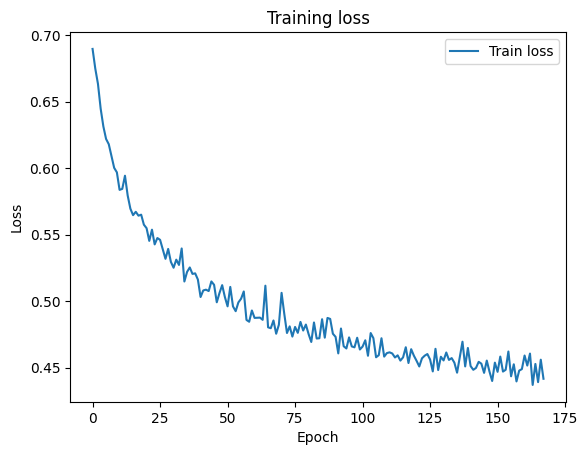

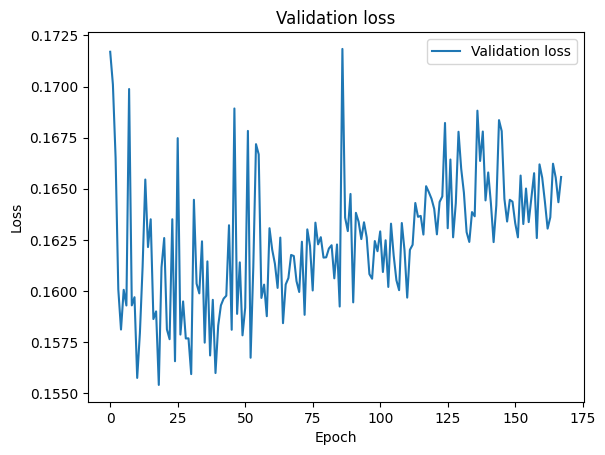

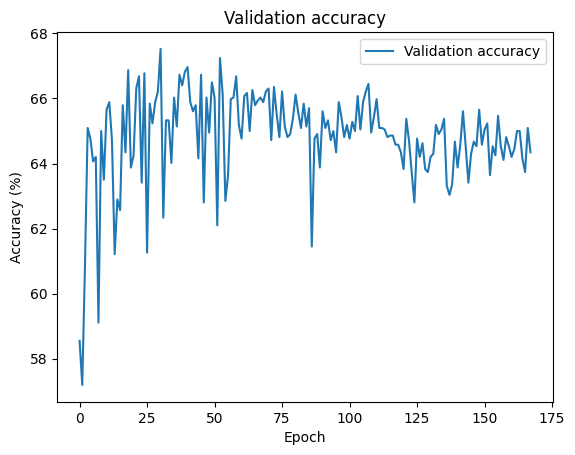

In [ ]:
plt.plot(train_losses, label="Train loss")
# label the plot
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
# save figure
plt.savefig(f"{version_prefix}_trainloss.png")
plt.show()


plt.plot(val_losses, label="Validation loss")
# label the plot
plt.title("Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
# save figure
plt.savefig(f"{version_prefix}_valloss.png")
plt.show()

plt.plot(val_accs, label="Validation accuracy")
# label the plot
plt.title("Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
# save figure
plt.savefig(f"{version_prefix}_valacc.png")
plt.show()

In [ ]:
model2 = torch.load("models/vit2_model_12_0.5835193874020326.pth")

In [ ]:
with torch.no_grad():
    correct, total = 0, 0
    test_loss = 0.0
    for batch in tqdm(test_loader, desc="Testing"):
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = model(x)
        loss = criterion(y_hat, y)
        test_loss += loss.detach().cpu().item() / len(test_loader)

        correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
        total += len(x)
    print(f"Test loss: {test_loss:.2f}")
    print(f"Test accuracy: {correct / total * 100:.2f}%")

Testing: 100%|██████████| 71/71 [04:20<00:00,  3.67s/it]

Test loss: 0.77
Test accuracy: 49.56%
